Using Spark SQL and Spark ML for simple data analytics
--------------------------------------------------------


This notebook show a few sample ways Spark SQL and Spark ML can be used to analyse data.
We will be using the wine quality dataset from: https://archive.ics.uci.edu/ml/datasets/Wine+Quality, which captures various physical properties of wines (alcohol content, acidity etc) and their quality as apprised by wine experts.

Let's start by creating an sqlContext and loading the data from the csv file to a `df` data frame.

In [1]:
#load contents of winequality-white.csv to spark dataframe
inputDF = spark.read.csv('data/winequality-white.csv',header='true', inferSchema='true', sep=';')

In [2]:
inputDF.printSchema()
print("Rows: %s" % inputDF.count())

root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)

Rows: 4898


Our dataframe is very small. In fact it is so small that we could easily analyse using standard python tools. However the code below,  which is currenlty running on a sigle computer can be easily run on large spark clusters to analyse dataframes with billions of rows.

Let's see as sample of the data:

In [3]:
display(inputDF.limit(5))

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


### Machine Learning with Spark ML

Here we will show a few example of using Spark ML to build regression models, predicting the quality of wine based it its properties.

We have called the new dataframe `data` and applied caching to it. This will tell Spark to try to cache the data in memory for faster access.

We will now try to build a simple lineary regression model that predicts wine quality `label` based on its properties. Spark requires that all the predictors (features) are combined into a single feature vector. We can use VectorAssemble to build it from selected columns of our dataframe (we will use all properties):

In [4]:
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

featureColumns = [c for c in inputDF.columns if c != 'quality']
assembler = VectorAssembler(inputCols=featureColumns, 
                            outputCol="features")
dataDF = assembler.transform(inputDF)
dataDF.printSchema()

root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)
 |-- features: vector (nullable = true)



In [5]:
display(dataDF.limit(5))

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,features
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,"[7.0, 0.27, 0.36, 20.7, 0.045, 45.0, 170.0, 1...."
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,"[6.3, 0.3, 0.34, 1.6, 0.049, 14.0, 132.0, 0.99..."
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,"[8.1, 0.28, 0.4, 6.9, 0.05, 30.0, 97.0, 0.9951..."
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,"[7.2, 0.23, 0.32, 8.5, 0.058, 47.0, 186.0, 0.9..."
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,"[7.2, 0.23, 0.32, 8.5, 0.058, 47.0, 186.0, 0.9..."


We can use the assembler to `transform` our input dataframe into one that includes the feature vector (`features`) and the response (`label`) as show above.

Now we are ready to build a simple regession model. We will first split our data into traning and testing set and then train a regression model on the former one. Rather then using our transformed `output` we will chaing the preprocessing (vector assemblling) and model traning into a simple `pipeline` that will alow us to use our original data. In general pipelines may include may steps dealing with feature preprocessing, extraction etc.

In [6]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(maxIter=30, regParam=0.3, elasticNetParam=0.3, featuresCol="features", labelCol="quality")
lrModel = lr.fit(dataDF)

We can now retrieve the linear regression model from the pipeline (stage 1) and look at the coefficients:  

In [7]:
for t in zip(featureColumns, lrModel.coefficients):
    print t

('fixed acidity', 0.0)
('volatile acidity', -0.79168917102449954)
('citric acid', 0.0)
('residual sugar', 0.0)
('chlorides', -0.10550323778501457)
('free sulfur dioxide', 0.0)
('total sulfur dioxide', 0.0)
('density', 0.0)
('pH', 0.0)
('sulphates', 0.0)
('alcohol', 0.19726471378350921)


You may notice that for most properties the coefficients are zero, which means that they do not contribute (accoriding to this specific model) to wine quality. This model is using elastic net regularisation which naturally 'selects' the most importnat variables.

Now we can use the testing set to evaluate the peformance of our model with Root Mean Squared Error:

In [8]:
predictionsDF = lrModel.transform(dataDF)
display(predictionsDF.limit(5))

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,features,prediction
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,"[7.0, 0.27, 0.36, 20.7, 0.045, 45.0, 170.0, 1....",5.546351
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,"[6.3, 0.3, 0.34, 1.6, 0.049, 14.0, 132.0, 0.99...",5.660263
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,"[8.1, 0.28, 0.4, 6.9, 0.05, 30.0, 97.0, 0.9951...",5.794351
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,"[7.2, 0.23, 0.32, 8.5, 0.058, 47.0, 186.0, 0.9...",5.793638
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,"[7.2, 0.23, 0.32, 8.5, 0.058, 47.0, 186.0, 0.9...",5.793638


In [9]:
from pyspark.ml.evaluation import RegressionEvaluator
# Make predictions.
predictionsDF = lrModel.transform(dataDF)
evaluator = RegressionEvaluator(
    labelCol='quality', predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictionsDF)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.794772


To get some insights into how good the model is we can try to compare it to the 'zero' model that predicts the mean of `quality`.

In [10]:
meanQuality = inputDF.groupBy().avg('quality').first()[0]
print(meanQuality)
zeroModelPredictionsDF = dataDF.selectExpr('quality',"CAST(%s AS DOUBLE) AS prediction" % meanQuality)
zeroModelRmse = evaluator.evaluate(zeroModelPredictionsDF)
print("RMSE of 'zero model' = %g" % zeroModelRmse)

5.87790935076
RMSE of 'zero model' = 0.885548


So we did a little bit better. But this is actually a very 'best case' estimate of the RMSE (Why?)

In [11]:
(trainingDF, testDF) = inputDF.randomSplit([0.7, 0.3])

In [12]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[assembler, lr])

lrPipelineModel = pipeline.fit(trainingDF)

traningPredictionsDF = lrPipelineModel.transform(trainingDF)
testPredictionsDF = lrPipelineModel.transform(testDF)

print("RMSE on traning data = %g" % evaluator.evaluate(traningPredictionsDF))
print("RMSE on test data = %g" % evaluator.evaluate(testPredictionsDF))

RMSE on traning data = 0.797945
RMSE on test data = 0.780064


Perhaps we can get better results if we can tune the parameters of the model. 

Spark ML comes with a ready to use parameter optimiser that uses cross validation from select the set of parameter from given search grid.

In [13]:
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator

search_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.0, 0.3, 0.6]) \
    .addGrid(lr.elasticNetParam, [0.4, 0.6, 0.8]).build()
    
cv = CrossValidator(estimator = pipeline, estimatorParamMaps = search_grid, evaluator = evaluator, numFolds = 3)
cvModel = cv.fit(trainingDF)

In [14]:
cvTestPredictionsDF = cvModel.transform(testDF)
print("RMSE on test data with CV = %g" % evaluator.evaluate(cvTestPredictionsDF))

RMSE on test data with CV = 0.756511


This model is slightly better than the guessed model.

In [15]:
print(cvModel.avgMetrics)

[0.7528934197616785, 0.8064551263586388, 0.851500570680301, 0.7528934197616785, 0.8264052993874931, 0.8826623213861144, 0.7528934197616785, 0.8407530553704714, 0.8935142323739377]


But perhaps we can do better with a more complex model? Let's try to use RandomForest.

In [16]:
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor(featuresCol="features", labelCol="quality", numTrees=100, maxBins=128, maxDepth=20, \
                           minInstancesPerNode=5, seed=33)
rfPipeline = Pipeline(stages=[assembler, rf])

# Train model.  This also runs the indexer.
rfPipelineModel = rfPipeline.fit(trainingDF)

In [17]:
rfModel = rfPipelineModel.stages[1]
rfModel.featureImportances

SparseVector(11, {0: 0.0596, 1: 0.1216, 2: 0.0625, 3: 0.0684, 4: 0.0783, 5: 0.1056, 6: 0.0652, 7: 0.1143, 8: 0.066, 9: 0.0549, 10: 0.2036})

In [18]:
rfTrainingPredictions = rfPipelineModel.transform(trainingDF)
rfTestPredictions = rfPipelineModel.transform(testDF)
print("Random Forest RMSE on traning data = %g" % evaluator.evaluate(rfTrainingPredictions))
print("Random Forest RMSE on test data = %g" % evaluator.evaluate(rfTestPredictions))

Random Forest RMSE on traning data = 0.413118
Random Forest RMSE on test data = 0.622631


Random forest 

In [19]:
rfPipelineModel.write().overwrite().save('output/rf.model')

In [20]:
from pyspark.ml import PipelineModel
loadedModel = PipelineModel.load('output/rf.model')
redPredictionsDF = loadedModel.transform(testDF)

In [21]:
print("Random Forest RMSE for red wine data = %g" % evaluator.evaluate(redPredictionsDF))

Random Forest RMSE for red wine data = 0.622631


### Data visualisation

Here we will use Principal Component Analysis to reduce the data dimesionalit so that we can plot the in 2D space.

As before we will create a multi step pipeline that will:

* assemble the feature vector from all predictors
* normalise the features (to 0 mean and 1 stddev) 
* extract two most significant PCA components


In [22]:
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import PCA
from pyspark.ml.feature import Normalizer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

all_assembler = VectorAssembler(
    inputCols=featureColumns,
    outputCol="features")
normalizer = Normalizer(inputCol="features", outputCol="norm_features")
pca = PCA(k=2, inputCol="norm_features", outputCol="pca_features")

pca_pipeline = Pipeline(stages=[all_assembler, normalizer, pca])

pca_model = pca_pipeline.fit(inputDF)

display(pca_model.transform(inputDF).select('features', 'norm_features', 'pca_features').limit(3))

,features,norm_features,pca_features
0,"[7.0, 0.27, 0.36, 20.7, 0.045, 45.0, 170.0, 1....","[0.0394465814369, 0.00152151099828, 0.00202868...","[0.00738132933449, -0.167246598583]"
1,"[6.3, 0.3, 0.34, 1.6, 0.049, 14.0, 132.0, 0.99...","[0.0472672209264, 0.00225082004412, 0.00255092...","[-0.146221111792, -0.153299522903]"
2,"[8.1, 0.28, 0.4, 6.9, 0.05, 30.0, 97.0, 0.9951...","[0.0789116854197, 0.00272781134784, 0.00389687...","[0.0445900247096, -0.104780780881]"


The `pca_features` column now contains the reduced 2D representation of all other features.

We can now use it to visualise a 30% sample of the data. The color represents quality of wine.


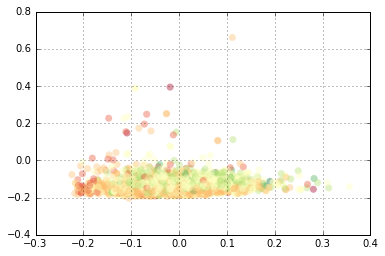

In [26]:
import numpy as np
import matplotlib.pyplot as plt
pca_data = pca_model.transform(inputDF)

sampling_fraction = 0.5

pca_xy = np.matrix(map(lambda r:r.pca_features.array, pca_data.sample(False, sampling_fraction, 13).collect()))
pca_colors = map(lambda r: float(r.quality),inputDF.select('quality').sample(False, sampling_fraction, 13).collect())

plt.scatter(pca_xy[:,0], pca_xy[:,1], c=pca_colors, alpha=0.4, cmap=plt.get_cmap('RdYlGn'), edgecolors='none', s=50)
plt.grid(True)
plt.show()
display()

Unfortunatelly Spark ML currently does not provide information on how much variance is explained by the two component or what they are.
Still there are some obvious areas dominated by good and bad quality wines.